<a href="https://colab.research.google.com/github/hidt4/python-compchem-book/blob/main/compchem_book_ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10章 反応機構を計算してみよう

### 環境構築

#### Google Colab上にPsi4をインストール

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y psi4=1.8 python=3.10 -c conda-forge/label/libint_dev -c conda-forge
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages')

--2024-06-05 11:44:56--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.177.84, 104.18.176.84, 2606:4700::6812:b054, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.177.84|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2024-06-05 11:44:56--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143808873 (137M) [application/octet-stream]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>] 137.15M   283MB/s    in 0.5s    

2024-06-05 11:44:56 (283 MB/s) - ‘Miniconda

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import psi4

print(f'current time: {datetime.datetime.now()}')
print(f'python version:\n{sys.version}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'psi4 version: {psi4.__version__}')

current time: 2024-06-05 11:46:59.409581
python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy version: 1.25.2
pandas version: 2.0.3
psi4 version: 1.8.2


#### 必要なライブラリと関数の定義

In [3]:
# 振動数可視化のためのライブラリ
!pip install py3Dmol
import py3Dmol

!git clone https://github.com/duerrsimon/normal-mode-jupyter.git
sys.path.append('/content/normal-mode-jupyter')
from helpers import show_normal_modes

Cloning into 'normal-mode-jupyter'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 8), reused 17 (delta 4), pack-reused 0
Receiving objects: 100% (23/23), 801.96 KiB | 16.04 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [4]:
def show_3D(mol: psi4.core.Molecule) -> py3Dmol.view:
    """
    Psi4のMoleculeオブジェクトをpy3Dmolで描画する
    Args:
        mol: 描画対象の分子

    Returns:
        py3Dmol.view: py3Dmolの描画オブジェクト

    """
    view = py3Dmol.view(width=400, height=400)
    xyz = mol.save_string_xyz_file()
    view.addModel(xyz, 'xyz')
    view.setStyle({'stick': {}})
    view.setBackgroundColor('#e1e1e1')
    view.zoomTo()

    return view.show()

In [5]:
def optfreq(mol: psi4.core.Molecule,
            theory: str) -> list[float, psi4.core.Wavefunction]:
    """
    分子の構造最適化と振動数計算を行う

    Args:
        mol (psi4.core.Molecule): 計算対象の分子
        theory: 計算レベル

    Returns:
        float: エネルギー
        psi4.core.Wavefunction: 計算のWavefunction

    """
    _, wfn = psi4.optimize(theory,
                           molecule=mol,
                           return_wfn=True)
    energy, wfn = psi4.frequency(theory,
                                 molecule=mol,
                                 ref_gradient=wfn.gradient(),
                                 return_wfn=True)

    return [energy, wfn]


def get_freqs(wavefunction: psi4.core.Wavefunction) -> np.ndarray:
    """
    Wavefunctionオブジェクトから振動数を取り出す
    Args:
        wavefunction: 対象のWavefunctionオブジェクト

    Returns:
        振動数のarrray

    """
    return wavefunction.frequencies().to_array()


#### 計算資源の設定

In [6]:
# 計算資源の確認（CPU, RAM）
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed smt_rsb srso
bogo

In [7]:
!cat /proc/meminfo

MemTotal:       53470712 kB
MemFree:        38406804 kB
MemAvailable:   52057032 kB
Buffers:          519920 kB
Cached:         13256916 kB
SwapCached:            0 kB
Active:          1902428 kB
Inactive:       12355204 kB
Active(anon):       1088 kB
Inactive(anon):   481192 kB
Active(file):    1901340 kB
Inactive(file): 11874012 kB
Unevictable:           8 kB
Mlocked:               8 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              4000 kB
Writeback:             0 kB
AnonPages:        480920 kB
Mapped:           346948 kB
Shmem:              1476 kB
KReclaimable:     503592 kB
Slab:             590960 kB
SReclaimable:     503592 kB
SUnreclaim:        87368 kB
KernelStack:        7024 kB
PageTables:         7448 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26735356 kB
Committed_AS:    3235572 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       12356 kB
VmallocChunk:    

In [8]:
n_cpu = os.cpu_count()
ram = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024 ** 3)

In [9]:
# 環境に応じて計算資源を設定
psi4.set_num_threads(n_cpu)
psi4.set_memory(f'{ram * 0.9: .0f}GB')

46000000000

### 10.2　遷移状態を計算してみよう

#### 1,2-ジクロロエタン

In [10]:
psi4.set_output_file('dce_ts.log')

# 二面角0度の初期構造
dce = psi4.geometry('''
0 1
 C                 -2.52697099    1.46473027    0.00000000
 H                 -2.17029815    1.96912846   -0.87365150
 H                 -3.59697099    1.46474345    0.00000000
 C                 -2.01365528    0.01279812    0.00000000
 H                 -2.84588587   -0.65972864    0.00000086
 H                 -1.41921341   -0.15534323   -0.87365174
 Cl                -1.94029417    2.29439458    1.43703425
 Cl                -1.03587983   -0.26377103    1.43703329
 ''')

In [11]:
# 遷移状態計算に設定
psi4.set_options({'opt_type': 'TS',
                  'normal_modes_write': True})

In [12]:
# 構造最適化・振動数計算
_, wfn_dce = optfreq(dce, 'hf/sto-3g')

Streaming output truncated to the last 5000 lines.
	Current energy:      -986.2882708116
	Energy change for the previous step:
		Actual       :        -0.0164631431
		Projected    :        -0.0456943061

INFO:psi4.optking.stepAlgorithms:	Energy ratio =    0.36029
INFO:psi4.optking.stepAlgorithms:	Internal forces in au, in Hevect basis:

		  0.000000 -0.000000  0.000000 -0.000000 -0.000000  0.000000 -0.000000
		 -0.000000 -0.000000 -0.000000 -0.000039  0.000460 -0.000420  0.000131
		 -0.000947 -0.001213  0.001394  0.001261 -0.001199  0.000312 -0.001064
		 -0.021674  0.000146 -0.017953  0.000154 -0.000008 -0.000003  0.034309

INFO:psi4.optking.stepAlgorithms:	RFO max
	  -0.000000  -0.000000
	  -0.000000   0.000000

INFO:psi4.optking.stepAlgorithms:	RFO min
	  -0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
	   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
	   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.00000

Optimizer: Optimization complete!


INFO:psi4.driver.driver:Return hessian(): -986.2910661701414
INFO:psi4.driver.driver:[[ 0.78437120  0.02313284 -0.06227891 -0.12262020 -0.05903120  0.11094526 -0.46907345 -0.00241534 -0.00022310
  -0.13193933  0.06209559  0.01437085  0.01318449 -0.02554954 -0.00407600 -0.00157659  0.02430974 -0.00088752
  -0.06483283 -0.03810273 -0.05347264 -0.00751328  0.01556064 -0.00437794]
 [ 0.02313284  0.62483615 -0.08108058 -0.05745369 -0.15038970  0.15966314 -0.00180662 -0.06736010  0.01123404
   0.05033130 -0.27100461 -0.00574954  0.01577388 -0.02104870 -0.00196544  0.00098240 -0.00681461  0.00502454
  -0.03438927 -0.10352671 -0.08962469  0.00342917 -0.00469171  0.00249853]
 [-0.06227891 -0.08108058  0.68217254  0.10940281  0.15740238 -0.33258978  0.00258568  0.00991981 -0.06916126
   0.00756930  0.01348577 -0.09861922  0.00020814  0.00280154  0.00367566  0.00523082 -0.02914947  0.00418342
  -0.05132850 -0.09569021 -0.18463014 -0.01138932  0.02231076 -0.00503123]
 [-0.12262020 -0.05745369  0.1

In [13]:
print(get_freqs(wfn_dce))

[-183.08771931  204.64536828  507.43941325  830.25721751  885.07518583
  990.53910526 1143.80098814 1238.19580398 1394.27022967 1476.30561586
 1550.19753259 1574.42163732 1766.48676142 1787.30939597 3616.23404455
 3620.17810198 3738.08344395 3745.69657017]


In [14]:
print(dce.save_string_xyz())

0 1
 C   -0.796640535505    0.546997795816   -0.984762465847
 H   -0.441167404410    1.057574884451   -1.879812149344
 H   -1.886629447806    0.546381111602   -0.994613833407
 C   -0.275677246855   -0.926094094901   -0.984841362467
 H   -1.123633903720   -1.610954135096   -0.994927287939
 H    0.321797028070   -1.099466879917   -1.879905409812
CL   -0.297026640830    1.568502026404    0.420906438912
CL    0.755204000742   -1.406521340795    0.420685163259



In [15]:
with open('dce_ts.xyz', 'w') as f:
    f.write(dce.save_string_xyz_file())

In [16]:
show_3D(dce)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
show_normal_modes('dce_ts.default.716.molden_normal_modes')

interactive(children=(Dropdown(description='Normal mode:', options=((-183.0877193102, 0), (204.6453682754, 1),…

### 10.3 遷移状態計算のコツ

In [18]:
import matplotlib.pyplot as plt

#### 反応座標軸に沿った構造のスキャン：SN2反応

##### スキャン

In [19]:
psi4.core.clean_options()
psi4.set_output_file('sn2_scan.log')

PosixPath('sn2_scan.log')

In [20]:
# Z座標を変数として扱えるように構造を定義
sn2_geom = '''
 -1 1
 C                 -0.37149818    0.23751522    0.00000000
 H                  0.13279358   -0.63613612    0.35682369
 H                 -1.38041486    0.23751522    0.35635256
 H                  0.13279358    1.11116656    0.35682369
 Cl                -0.37090351    0.23751522   -1.90999991
 Cl                -0.37090351    0.23751522   {}
'''

In [21]:
energies = []
geometries = []
distance = np.arange(1.7, 2.8, 0.1)
psi4.set_options({'GEOM_MAXITER': 200,
                  'FROZEN_DISTANCE': '1 6',
                  'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
                  'OPT_COORDINATES': 'CARTESIAN'})

# 距離を変えながら構造最適化
for dist in distance:
    ts = psi4.geometry(sn2_geom.format(dist))
    energy = psi4.optimize('b3lyp/6-31g(d)', molecule=ts)
    energies.append(energy)
    geometries.append(ts.save_string_xyz())

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


In [22]:
len(energies)

11

In [23]:
energies

[-960.3723509060425,
 -960.3792998445089,
 -960.3801972625619,
 -960.3781120885026,
 -960.3750054330028,
 -960.3720236158025,
 -960.3699857987365,
 -960.3697138534601,
 -960.371540833625,
 -960.3742232031877,
 -960.3766564714721]

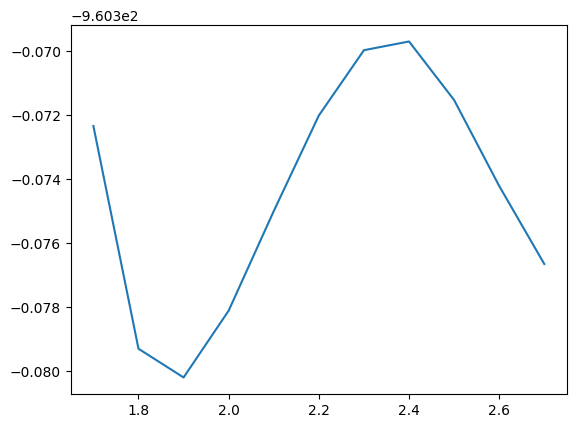

In [24]:
plt.plot(distance, energies)

In [25]:
# エネルギー最大値を与える距離を出力
idx = np.argmax(np.array(energies))
print(f'maximum energy at {distance[idx]: .1f} angstrom')

maximum energy at  2.4 angstrom


In [26]:
print(geometries[idx])

-1 1
 C    0.000188778598   -0.048832903451    0.000000000000
 H   -0.536238417575   -0.000924750267   -0.929160320890
 H    1.073127942312   -0.000881275602    0.000000000000
 H   -0.536238417575   -0.000924750267    0.929160320890
CL   -0.000077126041   -2.334367729586    0.000000000000
CL   -0.000006421032    2.351204055081    0.000000000000



##### 遷移状態の最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({'OPT_TYPE': 'TS',
                  'GEOM_MAXITER': 100,
                  'OPT_COORDINATES': 'CARTESIAN',
                  'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
                  'FULL_HESS_EVERY': 0,
                  'normal_modes_write': True})
psi4.set_output_file('SN2_OPT_TS.log')

PosixPath('SN2_OPT_TS.log')

In [ ]:
ts = psi4.geometry(geometries[7])
_, wfn_sn2 = optfreq(ts, 'b3lyp/6-31g(d)')

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             100
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

INFO:psi4.driver.driver:Return gradient(): -960.369552492203
INFO:psi4.driver.driver:[[-0.00000324  0.00003897  0.00000000]
 [-0.00033998 -0.00005261 -0.00058776]
 [ 0.00068039 -0.00005026  0.00000000]
 [-0.00033998 -0.00005261  0.00058776]
 [-0.00000159  0.00008396  0.00000000]
 [-0.00000051  0.00003251  0.00000000]]
INFO:psi4.optking.history:	Performing BOFILL update.
INFO:psi4.optking.history:	Using 1 previous steps for update.
INFO:psi4.optking.history:	Steps to be used in Hessian update:  1

INFO:psi4.optking.history:	Updated Hessian (in au) 
 	   0.697813  -0.000027   0.000000  -0.140222   0.007846  -0.144633  -0.390127
	  -0.015734   0.000000  -0.140222   0.007846   0.144633  -0.015418   0.000055
	   0.000000  -0.011831   0.000016   0.000000
	  -0.000027  -0.035921   0.000000   0.004778  -0.007818   0.008297  -0.009571
	  -0.007829   0.000000   0.004778  -0.007818  -0.008297   0.000001   0.031893
	   0.000000  -0.000010   0.027503   0.000000
	   0.000000   0.000000   0.698104  -

Optimizer: Optimization complete!


INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'FULL_HESS_EVERY': 0, 'GEOM_MAXITER': 100, 'INTRAFRAG_STEP_LIMIT_MAX': 0.5, 'SCF__INTS_TOLERANCE': 1e-12, 'NORMAL_MODES_WRITE': 1, 'OPT_COORDINATES': 'CARTESIAN', 'OPT_TYPE': 'TS', 'PARENT_SYMMETRY': 'CS(Z)', 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=b3lyp, basis=6-31g(d), molecule=CCl2H3, nre=108.57578271591338
INFO:psi4.driver.driver:Return gradient(): -960.3695542124341
INFO:psi4.driver.driver:[[-0.00006546 -0.00002693  0.00000000]
 [ 0.00007796  0.00001796  0.00007278]
 [-0.00010634  0.00000023  0.00000000]
 [ 0.00007796  0.00001796 -0.00007278]
 [ 0.00000435  0.00006077  0.00000000]
 [ 0.00000657 -0.00007023  0.00000000]]
INFO:psi4.driver.task_base:<<< JSON launch ... cs 108.57577829948943
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'FULL_HESS_EVERY': 0, 'GEOM_MAXI

In [ ]:
print(get_freqs(wfn_sn2))

[-329.0222871124382209  195.1018955111290722  195.1935600398248312
  211.4501640510802360  924.4845252158118001  924.6026013993157449
 1026.4286569256250914 1423.5110952898512551 1424.0708319230286634
 3234.0390187804364359 3429.4685686369330142 3429.5409279807086023]


In [ ]:
show_normal_modes('SN2_OPT_TS.CCl2H3.1004.molden_normal_modes')

interactive(children=(Dropdown(description='Normal mode:', options=((-329.0222871124, 0), (195.1018955111, 1),…

In [ ]:
print(ts.save_string_xyz())

-1 1
 C    0.243471047392    0.055984593807    0.000000000000
 H   -0.292613862163    0.030319307975   -0.930086497601
 H    1.316077033685    0.107249177664    0.000000000000
 H   -0.292613862163    0.030319307975    0.930086497601
CL    0.356877170765   -2.304213533562    0.000000000000
CL    0.130734523454    2.415767813584    0.000000000000



#### 簡単な遷移状態から始める

In [ ]:
ts_2 = psi4.geometry('''
-1 1
C        0.2649260080     -0.0067094977      0.0000000000
H       -0.2717752670     -0.0312506114     -0.9301314632
C        1.3381167522      0.0418605925      0.0000000000
C       -0.2717752670     -0.0312506114      0.9301314632
Cl       0.3727604714     -2.3688191841      0.0000000000
Cl       0.1571287303      2.3544767471      0.0000000000
H        1.6944025173      0.0582577786     -1.0088070112
H        1.7339248047     -0.8149079124      0.5041663560
H        1.6549282236      0.9306064646      0.5046397392
H       -1.3226464201     -0.0787576909      0.7343946575
H       -0.0531535919      0.8530376826      1.4915036894
H        0.0258452199     -0.8924765946      1.4910341746
''')

In [ ]:
show_3D(ts_2)

##### 制約付き最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'GEOM_MAXITER': 200,
    'FROZEN_CARTESIAN': '1 XYZ 5 XYZ 6 XYZ'
})
psi4.set_output_file('SN2_OPT2.log')

In [ ]:
psi4.optimize('b3lyp/6-31g(d)', molecule=ts_2)

In [ ]:
show_3D(ts_2)

##### 遷移状態最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'OPT_TYPE': 'TS',
    'GEOM_MAXITER': 100,
    'OPT_COORDINATES': 'CARTESIAN',
    'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
    'FULL_HESS_EVERY': 0,
    'NORMAL_MODES_WRITE': True,
})
psi4.set_output_file('SN2_OPT_TS2.log')

In [ ]:
_, wfn_sn2_2 = optfreq(ts_2, 'b3lyp/6-31g(d)')

In [ ]:
print(get_freqs(wfn_sn2_2))

In [ ]:
show_3D(ts_2)

In [ ]:
ts_2.save_xyz_file('sn2_ts2.xyz', True)

In [ ]:
print(ts_2.save_string_xyz())

### IRC計算で反応経路を求めてみよう

In [ ]:
ts = psi4.geometry('''
-1 1
 C    0.098421320532    0.054893520710    0.000000000000
 H   -0.438222232952    0.050608630789   -0.930076170940
 H    1.172017644302    0.062780757659    0.000000000000
 H   -0.438222232952    0.050608630789    0.930076170940
CL    0.116749836102   -2.307797321210    0.000000000000
CL    0.078906733689    2.416696245111    0.000000000000
''')

In [ ]:
forward = ts.clone()

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'OPT_TYPE': 'IRC',
    'IRC_DIRECTION': 'FORWARD',
    'IRC_POINTS': 20,
    'IRC_STEP_SIZE': 0.2,
    'FULL_HESS_EVERY': 0,
    'OPT_COORDINATES': 'CARTESIAN',
    'GEOM_MAXITER': 200
                  })

In [ ]:
psi4.set_output_file('sn2_irc_forward.log')
psi4.optimize('b3lyp/6-31g(d)', molecule=forward)

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =              50
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

INFO:psi4.driver.driver:Return gradient(): -960.3695756110519
INFO:psi4.driver.driver:[[ 0.00011680 -0.00134681  0.00000000]
 [ 0.00006403  0.00002002  0.00003538]
 [-0.00021541 -0.00002675  0.00000000]
 [ 0.00006403  0.00002002 -0.00003538]
 [-0.00000727  0.00076624  0.00000000]
 [-0.00002690  0.00056666  0.00000000]]
INFO:psi4.optking.molsys:Projected (PHP) Hessian matrix
	   0.699773   0.005665   0.000000  -0.140519  -0.001062  -0.145014  -0.392204
	  -0.002851   0.000000  -0.140519  -0.001062   0.145014  -0.013256  -0.000340
	   0.000000  -0.013275  -0.000350   0.000000
	   0.005665  -0.038232   0.000000  -0.001050  -0.006988  -0.001162  -0.002861
	  -0.007003   0.000000  -0.001050  -0.006988   0.001162  -0.000344   0.029601
	   0.000000  -0.000360   0.029611   0.000000
	   0.000000   0.000000   0.699618  -0.144896  -0.001126  -0.308078   0.000000
	   0.000000  -0.056953   0.144896   0.001126  -0.308078   0.000000   0.000000
	  -0.013232   0.000000   0.000000  -0.013278
	  -0.14051

Optimizer: Optimization complete!
[{'step_number': 0, 'q': [0.0009155772733453584, 0.0007060647923375058, 0.0, -1.0131937658038948, -0.00739120363608712, -1.7575892388910987, 2.0297185984969954, 0.015610782512539103, 0.0, -1.0131937658038948, -0.00739120363608712, 1.7575892388910987, 0.03555145198683493, -4.464132545563837, 0.0, -0.035961647311387346, 4.4638663762703805, 0.0], 'x': [[0.0009155772733453584, 0.0007060647923375058, 0.0], [-1.0131937658038948, -0.00739120363608712, -1.7575892388910987], [2.0297185984969954, 0.015610782512539103, 0.0], [-1.0131937658038948, -0.00739120363608712, 1.7575892388910987], [0.03555145198683493, -4.464132545563837, 0.0], [-0.035961647311387346, 4.4638663762703805, 0.0]], 'f_q': [-0.00010579638315485435, 3.9342702505077836e-05, 0.0, -9.031744476760417e-05, -2.522618000755486e-05, -8.1204227716139e-05, 0.00026846953818743247, 2.2136608644683338e-05, 0.0, -9.031744476760417e-05, -2.522618000755486e-05, 8.1204227716139e-05, 2.1160267726403974e-06, -0.0

-960.3691574731084